In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import timeit
import json

os.environ["DGLBACKEND"] = "pytorch"

from dgl import from_networkx
import networkx as nx


import torch as th
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import itertools

from src.graph_neural_networks import EGRAPHSAGE, EGAT, EGCN
from src.dataset.dataset_info import datasets
from src.graph.graph_measures import calculate_graph_measures

# datasets = {dataset.name: dataset for dataset in datasets_list}

num_epochs = 100
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001


In [2]:
name = "cic_ids_2017_5_percent"
# name = "cic_ton_iot_5_percent"
dataset = datasets[name]

In [3]:
results_final = {}

results_final["name"] = name
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    # "early_stopping": early_stopping,
    # "pca": pca,
    # "digraph_centralities": digraph_centralities,
    # "multi_graph_centralities": multi_graph_centralities,
    # "learning_rate": learning_rate,
    # "LAMBD_1": LAMBD_1,
    # "LAMBD_2": LAMBD_2,
    # "cfg": OmegaConf.to_container(cfg)
}

results_final["accuracy"] = {}
results_final["time_elapsed"] = {}

    
results_final["e_gcn"] = {}
results_final["e_gcn_res"] = {}

results_final["e_graph_sage"] = {}
results_final["e_graph_sage_res"] = {}

results_final["e_gat"] = {}
results_final["e_gat_res"] = {}


results_final

{'name': 'cic_bot_iot',
 'configuration': {'num_epochs': 100, 'batch_size': 128},
 'accuracy': {},
 'time_elapsed': {},
 'e_gcn': {},
 'e_gcn_res': {},
 'e_graph_sage': {},
 'e_graph_sage_res': {},
 'e_gat': {},
 'e_gat_res': {}}

In [4]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20241030-114155'

In [5]:
results_folder_path = "results"
if not os.path.isdir(results_folder_path):
    os.mkdir(results_folder_path)

results_folder_path1 = os.path.join(results_folder_path, name)
if not os.path.isdir(results_folder_path1):
    os.mkdir(results_folder_path1)

folder_path = os.path.join(results_folder_path1, dtime)
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)
    
confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
if not os.path.isdir(confusion_matrices_path):
    os.mkdir(confusion_matrices_path)

In [6]:
with open("datasets/" + name + "/training_graph.pkl", "rb") as f:
    G = pickle.load(f)

In [7]:
G = from_networkx(G,edge_attrs=['h',dataset.label_col] )

In [8]:
num_features = G.edata['h'].shape[1]
num_features

32

In [9]:
G.ndata['h'] = th.ones(G.num_nodes(), num_features)

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, num_features))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(G.edata[dataset.label_col].cpu().numpy()),
                                                 y = G.edata[dataset.label_col].cpu().numpy())

In [11]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight = class_weights)

In [12]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [13]:
def train_gnn(model_class, Graph, residual, num_neighbors = None):
    node_features = Graph.ndata['h']
    edge_features = Graph.edata['h']

    edge_label = Graph.edata[dataset.label_col]
    train_mask = Graph.edata['train_mask']

    # model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
    #                    dropout=0.2, num_neighbors=4, residual=residual)

    if num_neighbors:
        model = model_class(num_features, num_features, 128, F.relu,
                    dropout=0.2, num_neighbors=num_neighbors, residual=residual)
    else:
        model = model_class(num_features, num_features, 128, F.relu,
                    dropout=0.2, residual=residual)

    opt = th.optim.Adam(model.parameters())

    for epoch in range(1,num_epochs):
    #     pred = model(G, node_features,edge_features).cuda()
        pred = model(Graph, node_features,edge_features)
        loss = criterion(pred[train_mask] ,edge_label[train_mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

    return model

### Training EGCN

In [14]:
model_gcn = train_gnn(EGCN, G, False, None)

Epoch: 1  Training acc: 0.9965941905975342
Epoch: 2  Training acc: 0.996759831905365
Epoch: 3  Training acc: 0.996735155582428
Epoch: 4  Training acc: 0.9967880249023438
Epoch: 5  Training acc: 0.9968122243881226
Epoch: 6  Training acc: 0.996812105178833
Epoch: 7  Training acc: 0.996813178062439
Epoch: 8  Training acc: 0.9968143105506897
Epoch: 9  Training acc: 0.9968155026435852
Epoch: 10  Training acc: 0.9968156218528748
Epoch: 11  Training acc: 0.9968162178993225
Epoch: 12  Training acc: 0.9968156218528748
Epoch: 13  Training acc: 0.9968149662017822
Epoch: 14  Training acc: 0.9968160390853882
Epoch: 15  Training acc: 0.9968162178993225
Epoch: 16  Training acc: 0.9968244433403015
Epoch: 17  Training acc: 0.9968884587287903
Epoch: 18  Training acc: 0.9968160390853882
Epoch: 19  Training acc: 0.9968161582946777
Epoch: 20  Training acc: 0.9968247413635254
Epoch: 21  Training acc: 0.9969283938407898
Epoch: 22  Training acc: 0.9968278408050537
Epoch: 23  Training acc: 0.9968542456626892
E

### Training EGCN residual

In [15]:
model_gcn_res = train_gnn(EGCN, G, True, None)

Epoch: 1  Training acc: 0.38813674449920654
Epoch: 2  Training acc: 0.903118371963501
Epoch: 3  Training acc: 0.9640890955924988
Epoch: 4  Training acc: 0.987824022769928
Epoch: 5  Training acc: 0.994875967502594
Epoch: 6  Training acc: 0.9961442947387695
Epoch: 7  Training acc: 0.996283233165741
Epoch: 8  Training acc: 0.9962496161460876
Epoch: 9  Training acc: 0.9961916208267212
Epoch: 10  Training acc: 0.9906396865844727
Epoch: 11  Training acc: 0.9909707903862
Epoch: 12  Training acc: 0.9943615794181824
Epoch: 13  Training acc: 0.9951028227806091
Epoch: 14  Training acc: 0.9917383790016174
Epoch: 15  Training acc: 0.9937562942504883
Epoch: 16  Training acc: 0.9885355830192566
Epoch: 17  Training acc: 0.9952588677406311
Epoch: 18  Training acc: 0.9894472360610962
Epoch: 19  Training acc: 0.9906383156776428
Epoch: 20  Training acc: 0.9893627762794495
Epoch: 21  Training acc: 0.9947813749313354
Epoch: 22  Training acc: 0.9965559840202332
Epoch: 23  Training acc: 0.9276103973388672
Epo

### Training EGraphSage 

In [16]:
model_sage = train_gnn(EGRAPHSAGE, G, False, 4)

Epoch: 1  Training acc: 0.0066406275145709515
Epoch: 2  Training acc: 0.9966861009597778
Epoch: 3  Training acc: 0.9967384934425354
Epoch: 4  Training acc: 0.9968083500862122
Epoch: 5  Training acc: 0.9967866539955139
Epoch: 6  Training acc: 0.9968106150627136
Epoch: 7  Training acc: 0.9967896342277527
Epoch: 8  Training acc: 0.9968134760856628
Epoch: 9  Training acc: 0.9968152046203613
Epoch: 10  Training acc: 0.7418375015258789
Epoch: 11  Training acc: 0.9968122839927673
Epoch: 12  Training acc: 0.9968522787094116
Epoch: 13  Training acc: 0.5854063630104065
Epoch: 14  Training acc: 0.9968141317367554
Epoch: 15  Training acc: 0.9968093037605286
Epoch: 16  Training acc: 0.996810793876648
Epoch: 17  Training acc: 0.9968094229698181
Epoch: 18  Training acc: 0.9968143105506897
Epoch: 19  Training acc: 0.7713317275047302
Epoch: 20  Training acc: 0.9968163371086121
Epoch: 21  Training acc: 0.996866762638092
Epoch: 22  Training acc: 0.9968171715736389
Epoch: 23  Training acc: 0.8876250982284

### Training EGraphSage residual

In [17]:
model_sage_res = train_gnn(EGRAPHSAGE, G, True, 4)

Epoch: 1  Training acc: 0.7677134871482849
Epoch: 2  Training acc: 0.8136805891990662
Epoch: 3  Training acc: 0.9170630574226379
Epoch: 4  Training acc: 0.9596894979476929
Epoch: 5  Training acc: 0.988084614276886
Epoch: 6  Training acc: 0.988997757434845
Epoch: 7  Training acc: 0.9879688620567322
Epoch: 8  Training acc: 0.9956049919128418
Epoch: 9  Training acc: 0.9911310076713562
Epoch: 10  Training acc: 0.9552931785583496
Epoch: 11  Training acc: 0.6218027472496033
Epoch: 12  Training acc: 0.9898861050605774
Epoch: 13  Training acc: 0.7710314989089966
Epoch: 14  Training acc: 0.9922799468040466
Epoch: 15  Training acc: 0.9959914088249207
Epoch: 16  Training acc: 0.9909724593162537
Epoch: 17  Training acc: 0.9926040172576904
Epoch: 18  Training acc: 0.8557286858558655
Epoch: 19  Training acc: 0.9919679760932922
Epoch: 20  Training acc: 0.9919095635414124
Epoch: 21  Training acc: 0.9890590310096741
Epoch: 22  Training acc: 0.9860519766807556
Epoch: 23  Training acc: 0.9022325277328491

### Training EGAT

In [ ]:
model_gat = train_gnn(EGAT, G, False, None)

Epoch: 1  Training acc: 0.701066792011261
Epoch: 2  Training acc: 0.9616197347640991
Epoch: 3  Training acc: 0.9615924954414368
Epoch: 4  Training acc: 0.9615924954414368
Epoch: 5  Training acc: 0.9615892767906189
Epoch: 6  Training acc: 0.9615892767906189
Epoch: 7  Training acc: 0.9615697860717773
Epoch: 8  Training acc: 0.9615697860717773
Epoch: 9  Training acc: 0.9615697860717773
Epoch: 10  Training acc: 0.9615587592124939
Epoch: 11  Training acc: 0.9615587592124939
Epoch: 12  Training acc: 0.9615575075149536
Epoch: 13  Training acc: 0.9615575075149536
Epoch: 14  Training acc: 0.9615347981452942
Epoch: 15  Training acc: 0.9615283012390137
Epoch: 16  Training acc: 0.9615283012390137
Epoch: 17  Training acc: 0.9639151096343994
Epoch: 18  Training acc: 0.9663692712783813
Epoch: 19  Training acc: 0.970220148563385
Epoch: 20  Training acc: 0.9731794595718384
Epoch: 21  Training acc: 0.9763157963752747
Epoch: 22  Training acc: 0.976312518119812
Epoch: 23  Training acc: 0.976312518119812
E

### Training EGAT residual

In [ ]:
model_gat_res = train_gnn(EGAT, G, True, None)

Epoch: 1  Training acc: 0.6956643462181091
Epoch: 2  Training acc: 0.9494128823280334
Epoch: 3  Training acc: 0.9522646069526672
Epoch: 4  Training acc: 0.9668218493461609
Epoch: 5  Training acc: 0.966596245765686
Epoch: 6  Training acc: 0.9650685787200928
Epoch: 7  Training acc: 0.9645764827728271
Epoch: 8  Training acc: 0.963652491569519
Epoch: 9  Training acc: 0.9628555774688721
Epoch: 10  Training acc: 0.962414026260376
Epoch: 11  Training acc: 0.9621961712837219
Epoch: 12  Training acc: 0.9620774984359741
Epoch: 13  Training acc: 0.962162435054779
Epoch: 14  Training acc: 0.9623686671257019
Epoch: 15  Training acc: 0.9629165530204773
Epoch: 16  Training acc: 0.9641523957252502
Epoch: 17  Training acc: 0.965679407119751
Epoch: 18  Training acc: 0.9668776392936707
Epoch: 19  Training acc: 0.9699419736862183
Epoch: 20  Training acc: 0.9724059104919434
Epoch: 21  Training acc: 0.9749457240104675
Epoch: 22  Training acc: 0.9757458567619324
Epoch: 23  Training acc: 0.9758191108703613
Ep

# Testing

In [ ]:
with open("datasets/" + name + "/testing_graph.pkl", "rb") as f:
    G_test = pickle.load(f)

In [ ]:
G_test = from_networkx(G_test,edge_attrs=['h',dataset.label_col] )

In [ ]:
actual_label = G_test.edata.pop(dataset.label_col)
G_test.ndata['feature'] = th.ones(G_test.num_nodes(),num_features)

In [ ]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [ ]:
def test_gnn(model, graph):
    start_time = timeit.default_timer()
    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    # test_pred = model(G_test, node_features_test, edge_features_test).cuda()
    test_pred = model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    actual = ["Normal" if i == 0 else "Attack" for i in actual_label]
    test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred, elapsed)


In [ ]:

def calculate_FPR_FNR(cm):
 
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
 
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
 
    return FPR, FNR

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          file_path = None):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    if file_path:
        plt.savefig(file_path)
    plt.show()

### Testing EGCN

In [ ]:
actual, test_pred, elapsed = test_gnn(model_gcn, G_test)

0.6689356993883848 seconds


In [ ]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

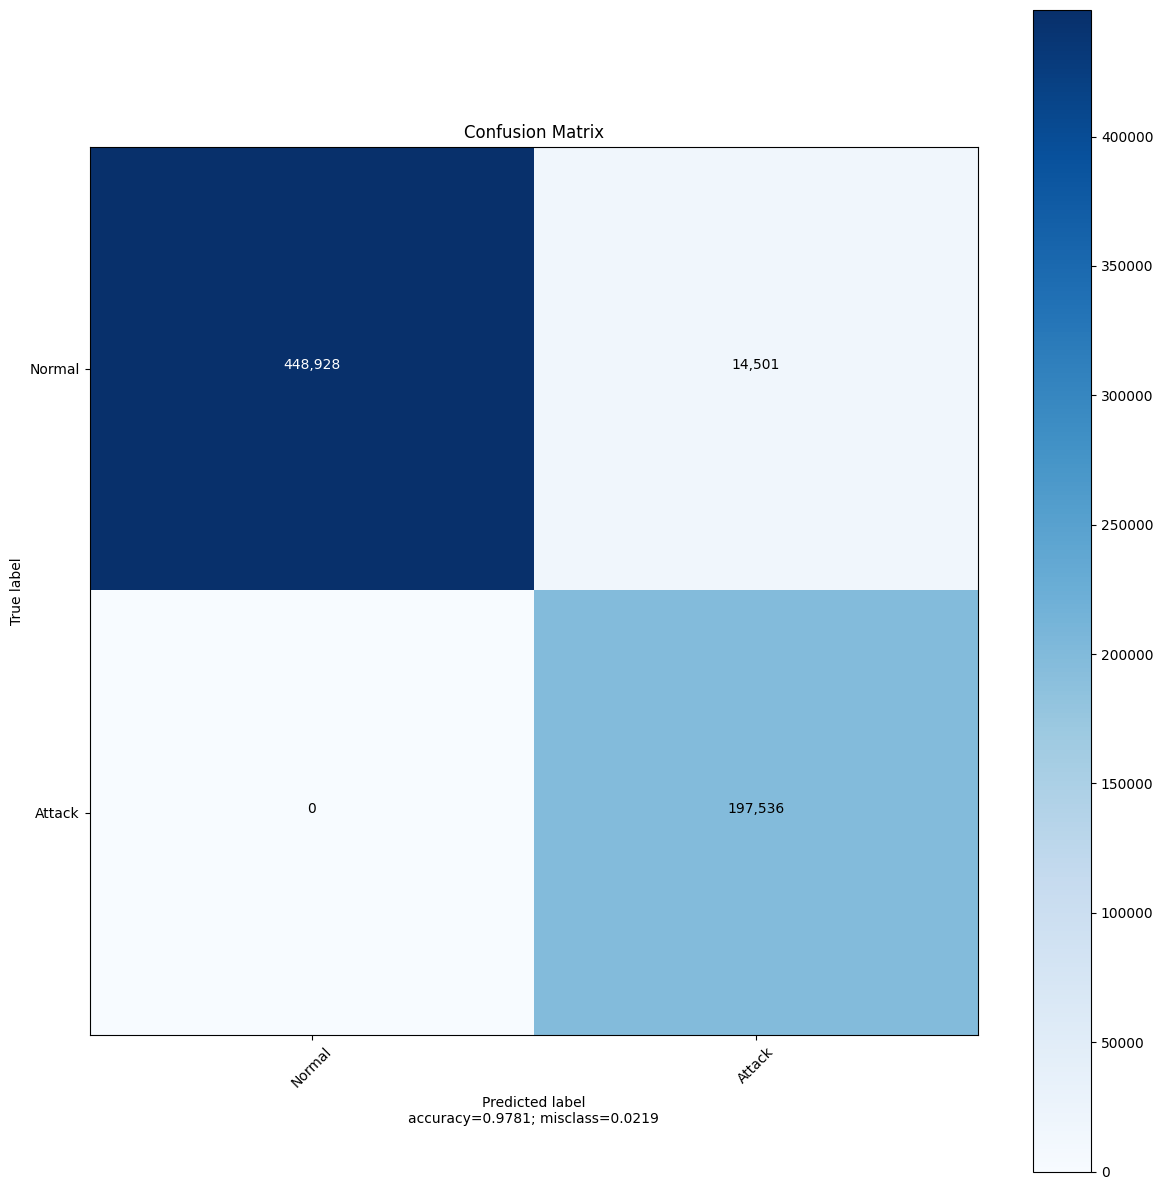

In [ ]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gcn.png')

In [ ]:
FPR, FNR = calculate_FPR_FNR(cm)

In [ ]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gcn"]["elapsed"] = elapsed
results_final["e_gcn"]["classification_report"] = cr
results_final["e_gcn"]["FPR"] = FPR
results_final["e_gcn"]["FNR"] = FNR
results_final["accuracy"]["e_gcn"] = cr["accuracy"]
results_final["time_elapsed"]["e_gcn"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9316    1.0000    0.9646    197536
      Normal     1.0000    0.9687    0.9841    463429

    accuracy                         0.9781    660965
   macro avg     0.9658    0.9844    0.9744    660965
weighted avg     0.9796    0.9781    0.9783    660965



### Testing EGCN residual

In [ ]:
actual, test_pred, elapsed = test_gnn(model_gcn_res, G_test)

0.7538578007370234 seconds


In [ ]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

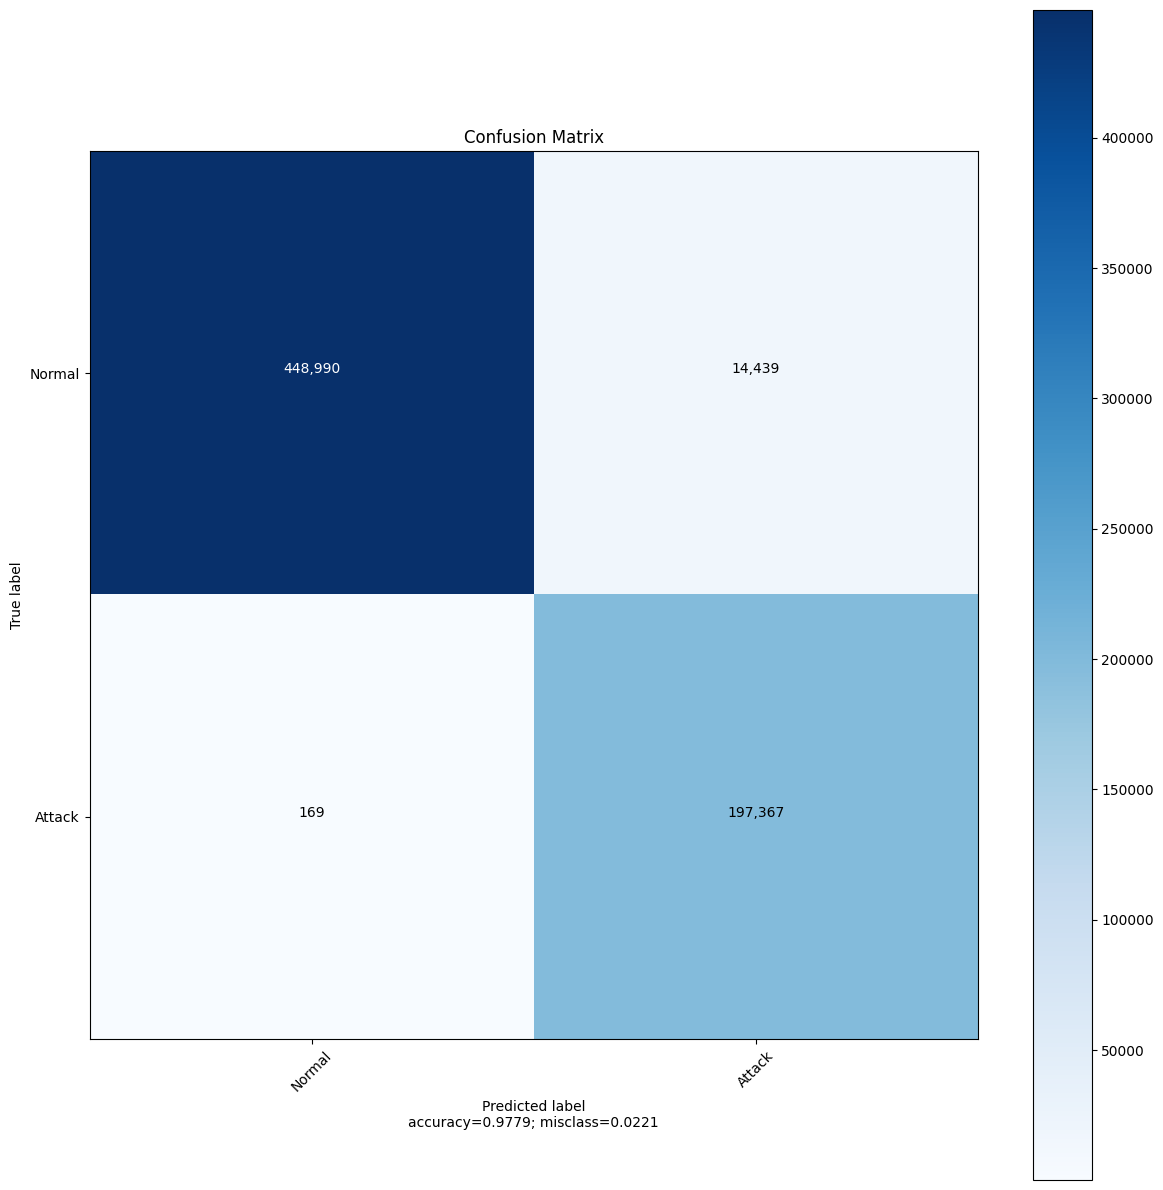

In [ ]:
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gcn_res.png')

In [ ]:
FPR, FNR = calculate_FPR_FNR(cm)

In [ ]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gcn_res"]["elapsed"] = elapsed
results_final["e_gcn_res"]["classification_report"] = cr
results_final["e_gcn_res"]["FPR"] = FPR
results_final["e_gcn_res"]["FNR"] = FNR
results_final["accuracy"]["e_gcn_res"] = cr["accuracy"]
results_final["time_elapsed"]["e_gcn_res"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9318    0.9991    0.9643    197536
      Normal     0.9996    0.9688    0.9840    463429

    accuracy                         0.9779    660965
   macro avg     0.9657    0.9840    0.9742    660965
weighted avg     0.9794    0.9779    0.9781    660965



### Testing EGraphSage

In [ ]:
actual, test_pred, elapsed = test_gnn(model_sage, G_test)

0.2896875012665987 seconds


In [ ]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

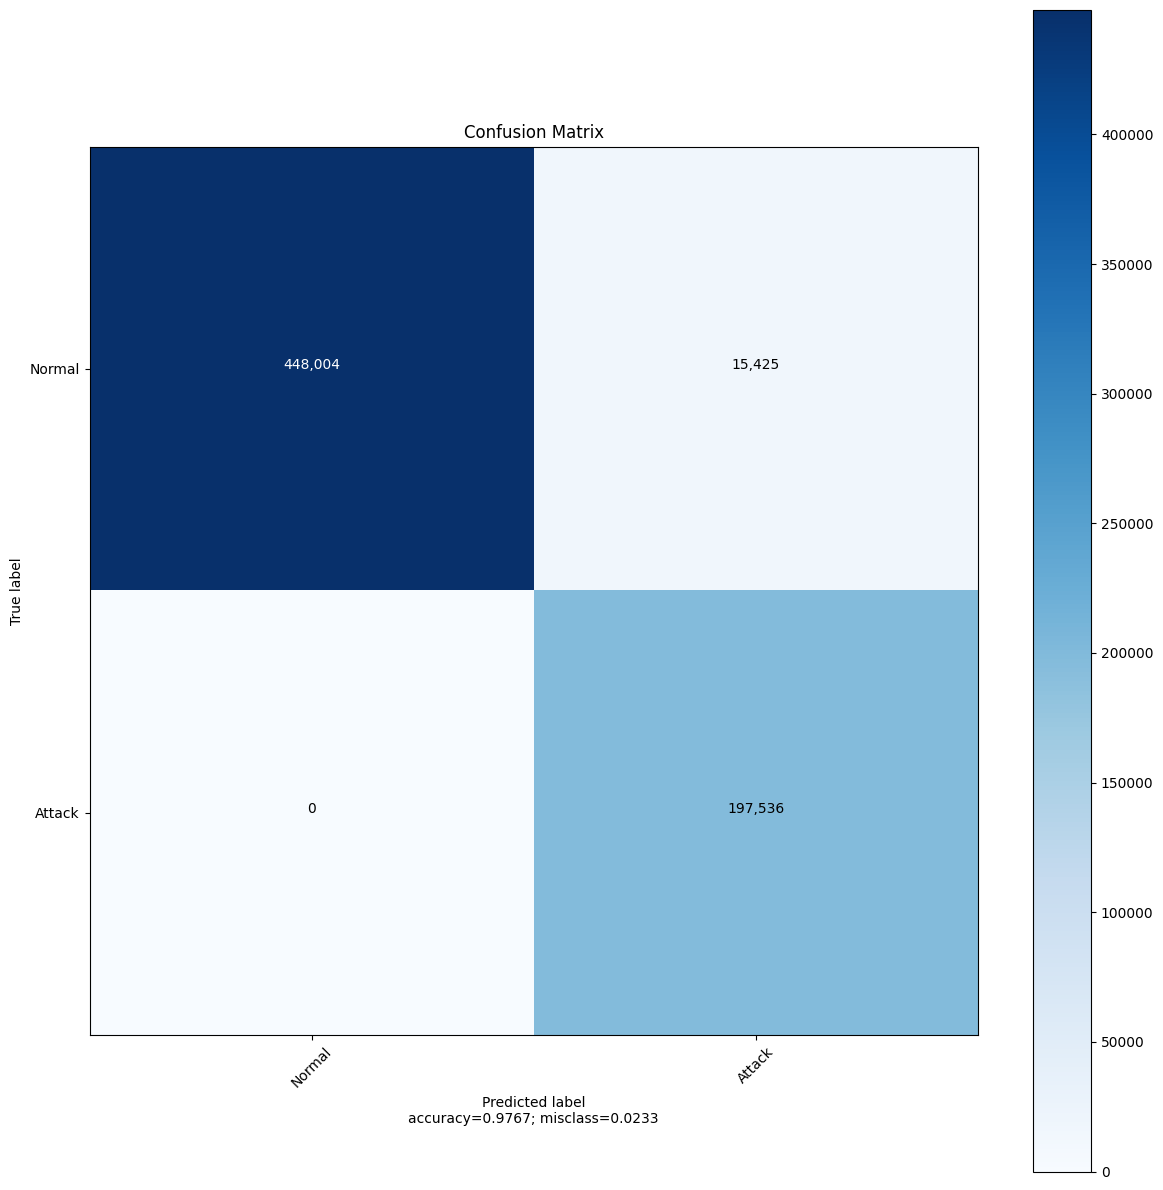

In [ ]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_graph_sage.png')

In [ ]:
FPR, FNR = calculate_FPR_FNR(cm)

In [ ]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_graph_sage"]["elapsed"] = elapsed
results_final["e_graph_sage"]["classification_report"] = cr
results_final["e_graph_sage"]["FPR"] = FPR
results_final["e_graph_sage"]["FNR"] = FNR
results_final["accuracy"]["e_graph_sage"] = cr["accuracy"]
results_final["time_elapsed"]["e_graph_sage"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9276    1.0000    0.9624    197536
      Normal     1.0000    0.9667    0.9831    463429

    accuracy                         0.9767    660965
   macro avg     0.9638    0.9834    0.9727    660965
weighted avg     0.9784    0.9767    0.9769    660965



### Testing EGraphSage residual

In [ ]:
actual, test_pred, elapsed = test_gnn(model_sage_res, G_test)

0.16059079952538013 seconds


In [ ]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

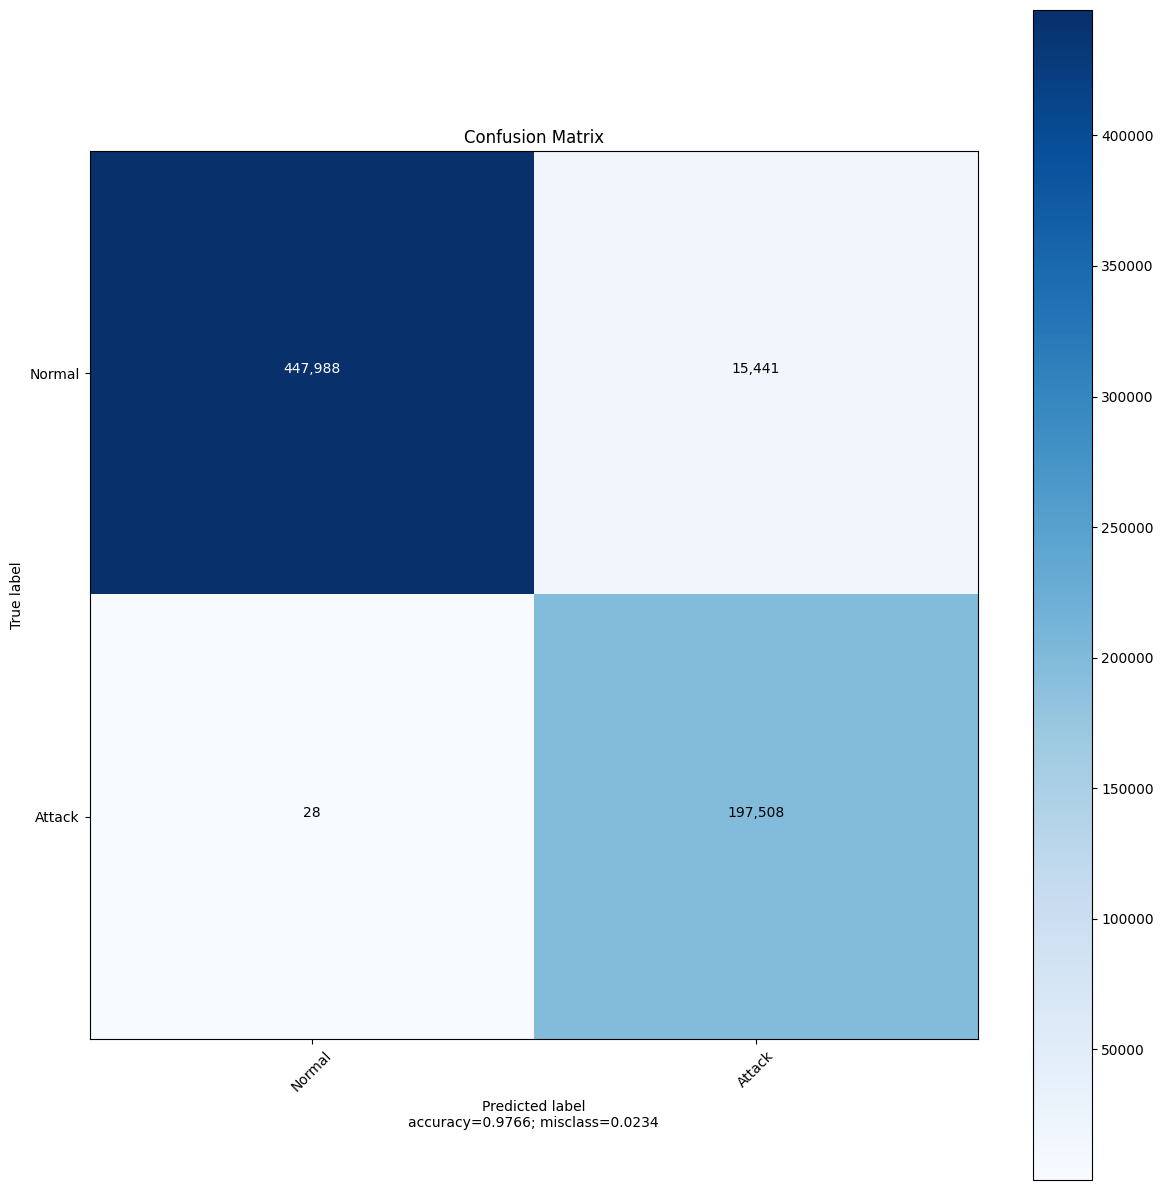

In [ ]:
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_graph_sage_res.png')

In [ ]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_graph_sage_res"]["elapsed"] = elapsed
results_final["e_graph_sage_res"]["classification_report"] = cr
results_final["e_graph_sage_res"]["FPR"] = FPR
results_final["e_graph_sage_res"]["FNR"] = FNR
results_final["accuracy"]["e_graph_sage_res"] = cr["accuracy"]
results_final["time_elapsed"]["e_graph_sage_res"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9275    0.9999    0.9623    197536
      Normal     0.9999    0.9667    0.9830    463429

    accuracy                         0.9766    660965
   macro avg     0.9637    0.9833    0.9727    660965
weighted avg     0.9783    0.9766    0.9768    660965



### Testing EGAT

In [ ]:
actual, test_pred, elapsed = test_gnn(model_gat, G_test)

2.53208339959383 seconds


In [ ]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

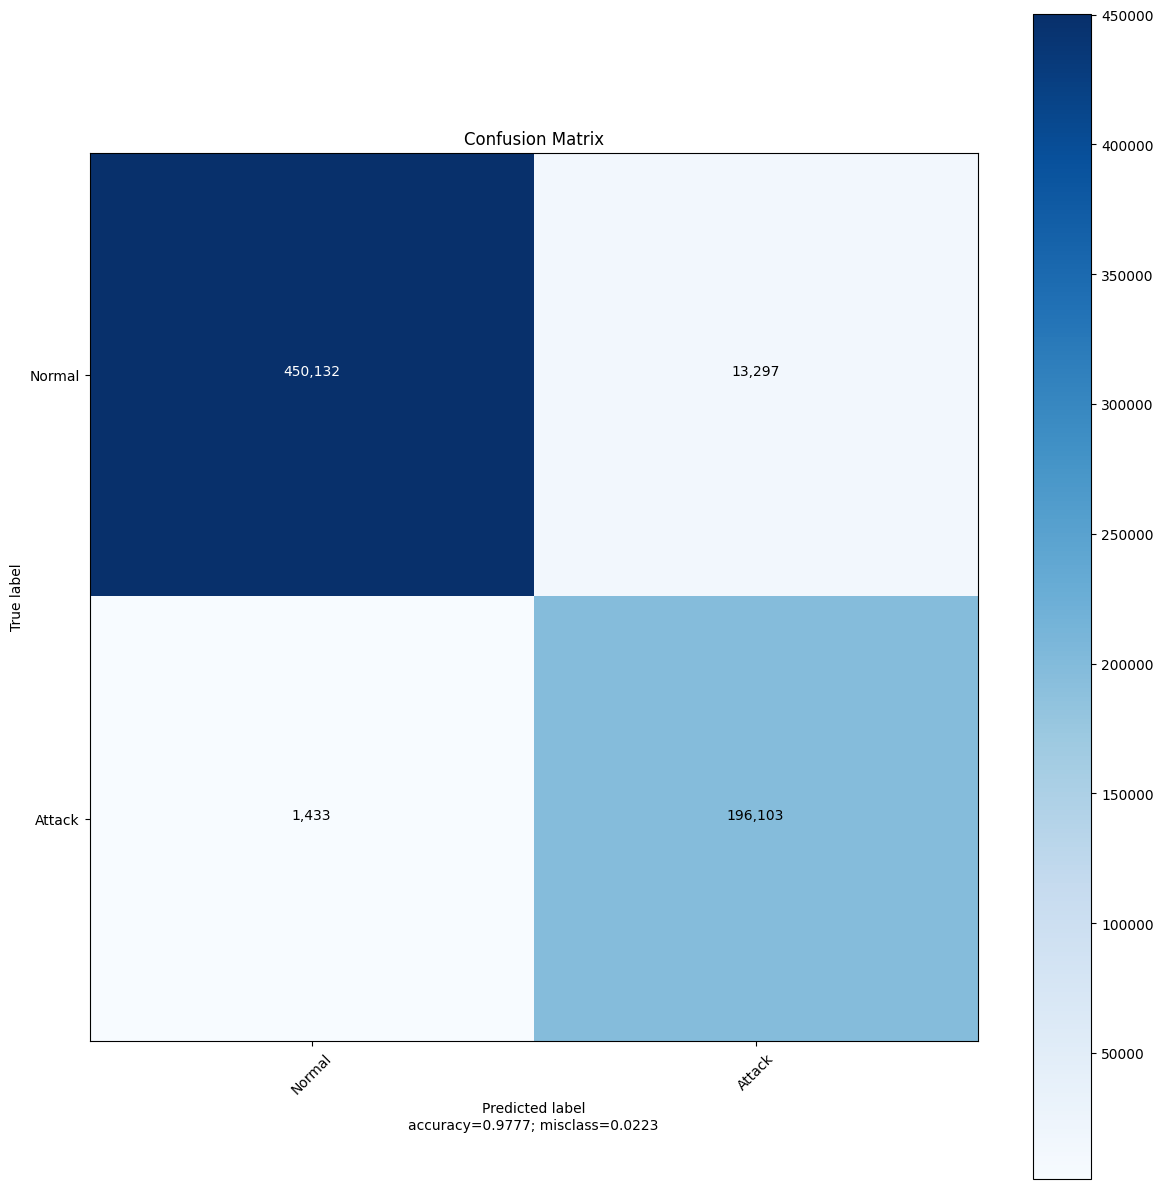

In [ ]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gat.png')

In [ ]:
FPR, FNR = calculate_FPR_FNR(cm)

In [ ]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gat"]["elapsed"] = elapsed
results_final["e_gat"]["classification_report"] = cr
results_final["e_gat"]["FPR"] = FPR
results_final["e_gat"]["FNR"] = FNR
results_final["accuracy"]["e_gat"] = cr["accuracy"]
results_final["time_elapsed"]["e_gat"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9365    0.9927    0.9638    197536
      Normal     0.9968    0.9713    0.9839    463429

    accuracy                         0.9777    660965
   macro avg     0.9667    0.9820    0.9739    660965
weighted avg     0.9788    0.9777    0.9779    660965



### Testing EGAT residual

In [ ]:
actual, test_pred, elapsed = test_gnn(model_gat_res, G_test)

2.4461161009967327 seconds


In [ ]:
labels = ["Normal", "Attack"]
cm = confusion_matrix(actual, test_pred, labels= labels)

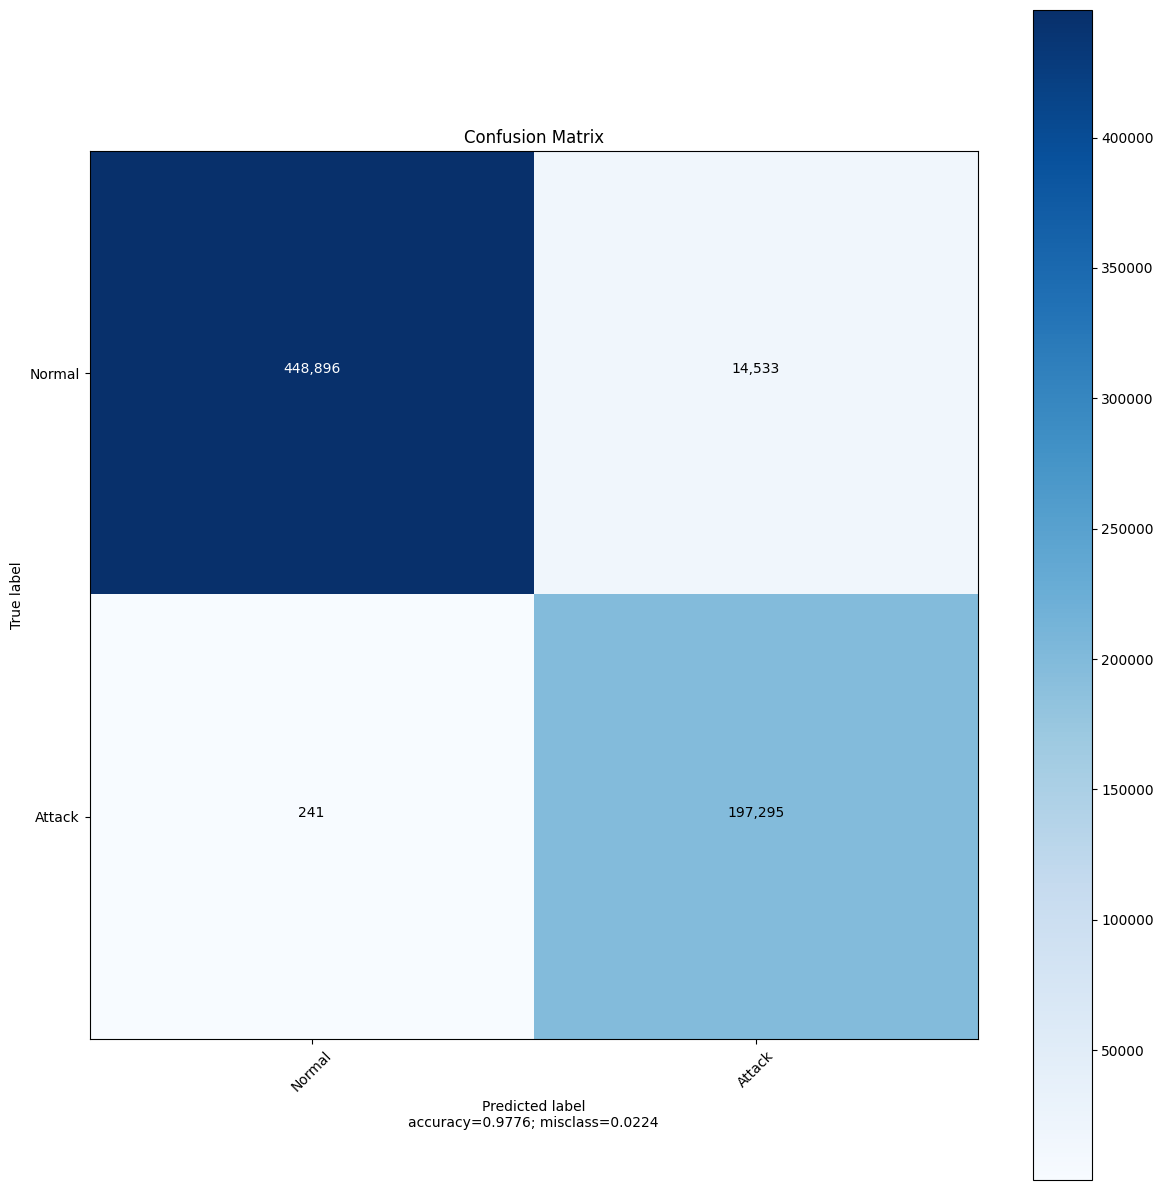

In [ ]:
plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix",
                      file_path = confusion_matrices_path + '/e_gat_res.png')

In [ ]:
FPR, FNR = calculate_FPR_FNR(cm)

In [ ]:
cr = classification_report(actual, test_pred, digits=4, output_dict=True)
results_final["e_gat_res"]["elapsed"] = elapsed
results_final["e_gat_res"]["classification_report"] = cr
results_final["e_gat_res"]["FPR"] = FPR
results_final["e_gat_res"]["FNR"] = FNR
results_final["accuracy"]["e_gat_res"] = cr["accuracy"]
results_final["time_elapsed"]["e_gat_res"] = elapsed

print(classification_report(actual, test_pred, digits=4))

              precision    recall  f1-score   support

      Attack     0.9314    0.9988    0.9639    197536
      Normal     0.9995    0.9686    0.9838    463429

    accuracy                         0.9776    660965
   macro avg     0.9654    0.9837    0.9739    660965
weighted avg     0.9791    0.9776    0.9779    660965



### Saving results

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

filename = (folder_path + '/results.json'.format(dtime))
outfile = open(filename, 'w')
outfile.writelines(json.dumps(results_final, cls=NumpyEncoder))
outfile.close()